In [2]:
#read in two separate rasters
# import libraries and functions here
import numpy as np
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt

from shapely.geometry import Polygon

# used to access STAC catalogs
from pystac_client import Client
# used to sign items from the MPC STAC catalog
import planetary_computer

# ----- other libraries for nice ouputs
from IPython.display import Image
import contextily as ctx #for adding basemaps

In [3]:
#load phoenix subdivision data

phoenix_sub = gpd.read_file("data/tl_2022_04_cousub")


In [4]:
#access catalog 

catalog = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1',
                     modifier = planetary_computer.sign_inplace)

In [5]:
catalog.get_collections()

<generator object Client.get_collections at 0x196df98b0>

In [6]:
# get collections and print their names
collections = list(catalog.get_collections())

print('Number of collections:', len(collections))
print("Collections IDs:")
for collection in collections:
    print('-', collection.id)

Number of collections: 122
Collections IDs:
- daymet-annual-pr
- daymet-daily-hi
- 3dep-seamless
- 3dep-lidar-dsm
- fia
- sentinel-1-rtc
- gridmet
- daymet-annual-na
- daymet-monthly-na
- daymet-annual-hi
- daymet-monthly-hi
- daymet-monthly-pr
- gnatsgo-tables
- hgb
- cop-dem-glo-30
- cop-dem-glo-90
- goes-cmi
- terraclimate
- nasa-nex-gddp-cmip6
- gpm-imerg-hhr
- gnatsgo-rasters
- 3dep-lidar-hag
- 3dep-lidar-intensity
- 3dep-lidar-pointsourceid
- mtbs
- noaa-c-cap
- 3dep-lidar-copc
- modis-64A1-061
- alos-fnf-mosaic
- 3dep-lidar-returns
- mobi
- landsat-c2-l2
- era5-pds
- chloris-biomass
- kaza-hydroforecast
- planet-nicfi-analytic
- modis-17A2H-061
- modis-11A2-061
- daymet-daily-pr
- 3dep-lidar-dtm-native
- 3dep-lidar-classification
- 3dep-lidar-dtm
- gap
- modis-17A2HGF-061
- planet-nicfi-visual
- gbif
- modis-17A3HGF-061
- modis-09A1-061
- alos-dem
- alos-palsar-mosaic
- deltares-water-availability
- modis-16A3GF-061
- modis-21A2-061
- us-census
- jrc-gsw
- deltares-floods
- modi

In [7]:
io_collection = catalog.get_child('io-biodiversity')
io_collection

<CollectionClient id=io-biodiversity>

In [8]:
time_range = "2017-01-01/2017-12-31"

bbox =  [-112.826843, 32.974108, -111.184387, 33.863574]

# catalog search
search = catalog.search(
    collections=['io-biodiversity'],
    bbox = bbox,
    datetime=time_range)

search

In [9]:
time_range1 = "2020-01-01/2020-12-31"
# catalog search
search2 = catalog.search(
    collections=['io-biodiversity'],
    bbox = bbox,
    datetime=time_range1)

search

In [10]:
items = search.item_collection()
len(items)

items2 = search2.item_collection()
len(items2)

1

In [11]:
#get all the items of the catalog search
item = items[0]
item2 = items2[0]

In [12]:
# print item id and properties
print('id:' , item.id)
item.properties

# print item id and properties
print('id:' , item2.id)
item2.properties

id: bii_2017_34.74464974521749_-115.38597824385106_cog
id: bii_2020_34.74464974521749_-115.38597824385106_cog


{'datetime': None,
 'proj:epsg': 4326,
 'proj:shape': [7992, 7992],
 'end_datetime': '2020-12-31T23:59:59Z',
 'proj:transform': [0.0008983152841195215,
  0.0,
  -115.38597824385106,
  0.0,
  -0.0008983152841195215,
  34.74464974521749,
  0.0,
  0.0,
  1.0],
 'start_datetime': '2020-01-01T00:00:00Z'}

In [13]:

print('datetime' , item.datetime)
print('end datetime', item.properties['end_datetime'])
print('start datetime', item.properties['start_datetime'])


print('datetime' , item2.datetime)
print('end datetime', item2.properties['end_datetime'])
print('start datetime', item2.properties['start_datetime'])

datetime None
end datetime 2017-12-31T23:59:59Z
start datetime 2017-01-01T00:00:00Z
datetime None
end datetime 2020-12-31T23:59:59Z
start datetime 2020-01-01T00:00:00Z


In [14]:
item.assets

{'data': <Asset href=https://pcdata01euw.blob.core.windows.net/impact/bii-v1/bii_2017/bii_2017_34.74464974521749_-115.38597824385106_cog.tif?st=2023-12-06T18%3A24%3A08Z&se=2023-12-07T19%3A09%3A08Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-12-07T17%3A37%3A23Z&ske=2023-12-14T17%3A37%3A23Z&sks=b&skv=2021-06-08&sig=EaOt%2BK7nFHNpAJuygq/WjnP9zcDi80mmYnxnQTO74zk%3D>,
 'tilejson': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=io-biodiversity&item=bii_2017_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.97%2A%28data_b1%2A%2A3.84%29&format=png>,
 'rendered_preview': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=io-biodiversity&item=bii_2017_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.

In [15]:
item2.assets

{'data': <Asset href=https://pcdata01euw.blob.core.windows.net/impact/bii-v1/bii_2020/bii_2020_34.74464974521749_-115.38597824385106_cog.tif?st=2023-12-06T18%3A24%3A08Z&se=2023-12-07T19%3A09%3A08Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-12-07T17%3A37%3A23Z&ske=2023-12-14T17%3A37%3A23Z&sks=b&skv=2021-06-08&sig=EaOt%2BK7nFHNpAJuygq/WjnP9zcDi80mmYnxnQTO74zk%3D>,
 'tilejson': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/tilejson.json?collection=io-biodiversity&item=bii_2020_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.97%2A%28data_b1%2A%2A3.84%29&format=png>,
 'rendered_preview': <Asset href=https://planetarycomputer.microsoft.com/api/data/v1/item/preview.png?collection=io-biodiversity&item=bii_2020_34.74464974521749_-115.38597824385106_cog&assets=data&tile_format=png&colormap_name=io-bii&rescale=0%2C1&expression=0.

In [16]:
mc = rioxr.open_rasterio(item.assets['data'].href)
mc

mc2 = rioxr.open_rasterio(item2.assets['data'].href)
mc2

<xarray.DataArray (band: 1, y: 7992, x: 7992)>
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57 27.57
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

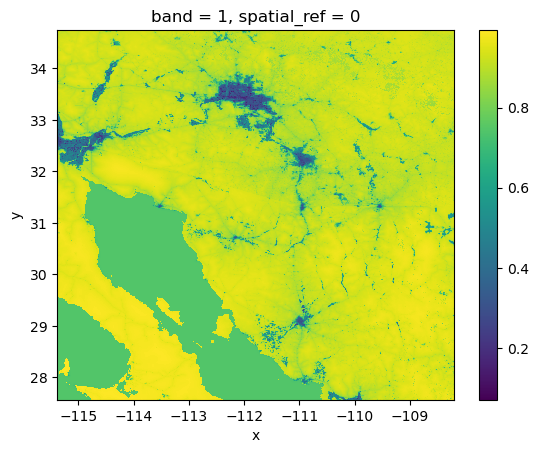

In [17]:
mc.plot()

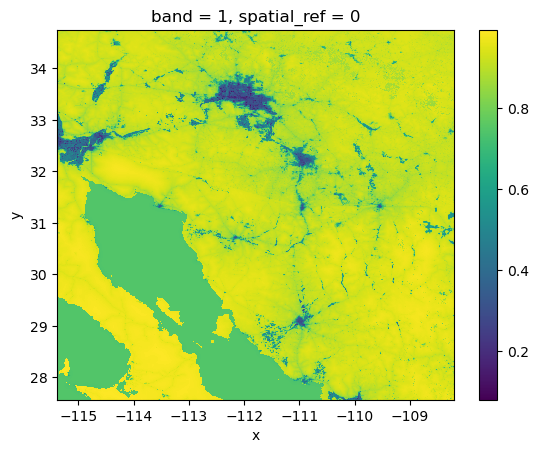

In [18]:
mc2.plot()

In [19]:
print(type(mc))
phoenix_sub.head()

<class 'xarray.core.dataarray.DataArray'>


,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CNECTAFP,NECTAFP,NCTADVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,None,None,None,S,12231052883,44653332,+35.1066114,-111.3662497,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,None,None,None,S,7228864534,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,None,None,None,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."
3,04,023,92295,01934961,0402392295,Nogales,Nogales CCD,22,Z5,G4040,None,None,None,S,1762322938,2382710,+31.4956020,-111.0171332,"POLYGON ((-111.36692 31.52136, -111.36316 31.5..."
4,04,023,92550,01934966,0402392550,Patagonia,Patagonia CCD,22,Z5,G4040,None,None,None,S,1439530300,685527,+31.5664619,-110.6410279,"POLYGON ((-110.96273 31.68695, -110.96251 31.6..."


In [20]:
phoenix_sub.NAME.values

array(['Flagstaff', 'Kaibab Plateau', 'Hualapai', 'Nogales', 'Patagonia',
       'Hopi', 'Tuba City', 'Clifton', 'Duncan', 'Chandler', 'Phoenix',
       'Tonto National Forest', 'Gila Bend', 'Wickenburg', 'Deer Valley',
       'Buckeye', 'St. Johns', 'Salt River', 'Tucson', 'Arivaca',
       'Indian Wells', 'Winslow-Holbrook', 'Snowflake', 'Kayenta',
       'Lake Havasu City', 'Fort Apache', 'Bisbee', 'Bowie', 'Willcox',
       'North Mohave', 'Kingman', 'Bullhead City', 'Congress',
       'Mingus Mountain', 'Florence', 'North Pinal', 'San Manuel', 'Eloy',
       'Chinle', 'Fort Apache', 'Sweetwater', 'Fort Defiance',
       'Dennehotso', 'Puerco', 'Ash Fork', 'Cordes Lakes-Mayer',
       'Camp Verde-Sedona', 'Prescott', 'Hopi', 'Piñon', 'Fort Apache',
       'Payson', 'Winkelman', 'Globe-Miami', 'Tonto Basin', 'Gila River',
       'Casa Grande', 'Maricopa-Stanfield', "Tohono O'odham Nation",
       'Coolidge', 'Ajo', 'Marana', "Tohono O'odham Nation", 'Somerton',
       'Bonita-Klondy

In [21]:
#filter for the phoenix dataset 
maricopa = phoenix_sub[phoenix_sub.NAME == "Phoenix"]

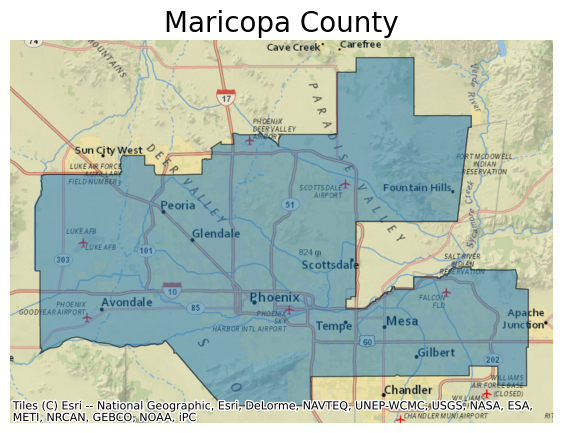

In [22]:
# create axis with plot
ax = (maricopa.to_crs(epsg=3857)
      .plot(figsize=(7, 7), alpha=0.5, edgecolor="k")
      )

# add basemap from contextily
ctx.add_basemap(ax, source=ctx.providers.Esri.NatGeoWorldMap)

# update axes
ax.set_title("Maricopa County", fontdict={"fontsize": "20"})
ax.set_axis_off()

In [46]:
#clipping 

#check the crs 
#mc.rio.crs == 4326

maricopa.crs = "epsg:4326"

maricopa.crs == mc.rio.crs

#clip the data 
maricopa.head


#clip the data 

clip_2017 = (mc.rio.clip(maricopa.geometry))
clip_2020 = (mc2.rio.clip(maricopa.geometry))


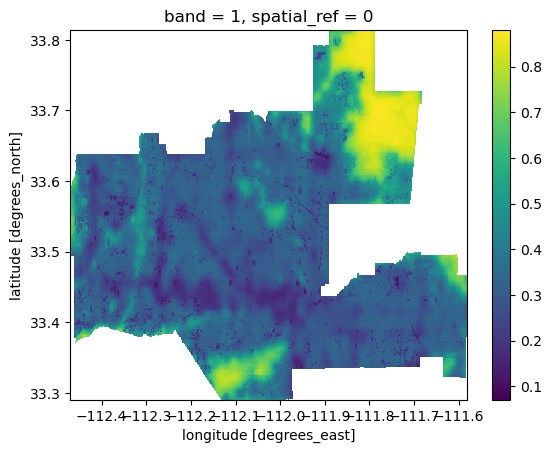

In [52]:
clip_2017.plot()

In [54]:
greater_data2017 = (clip_2017>=.75)

greater_int2017 = greater_data2017.astype(int)

greater_data2020 = (clip_2020>=.75)

greater_int2020 = greater_data2020.astype(int)

In [57]:
new = greater_int2017 - greater_int2020

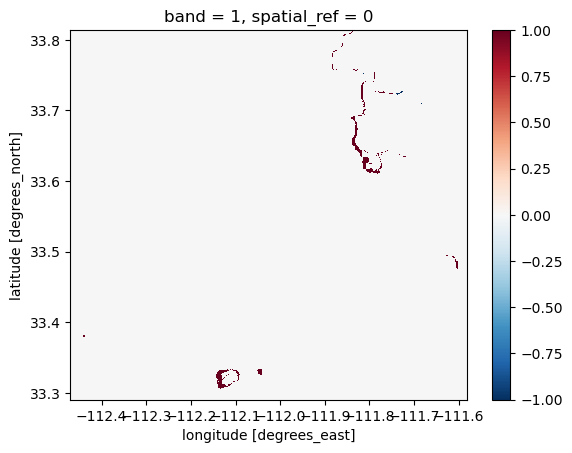

In [59]:
new.plot()

In [79]:
#find the percentage area 
percent_area = (new.sum() / new.count())*100


<xarray.DataArray ()>
array(True)
Coordinates:
    spatial_ref  int64 0